Epoch 1/10
8/8 [==============================] - 1s 29ms/step - loss: 0.9363 - accuracy: 0.6653 - val_loss: 0.5933 - val_accuracy: 1.0000
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.4593 - accuracy: 0.9582 - val_loss: 0.1962 - val_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1550 - accuracy: 0.9958 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9958 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 9.9107e-04 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 6.2579e-04 - val_accuracy: 1.0000
Epoch 8/10
8/8 [=========

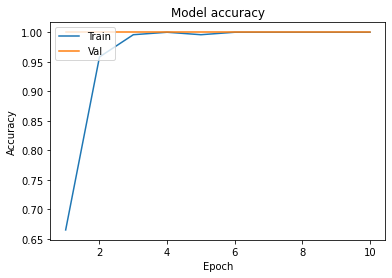

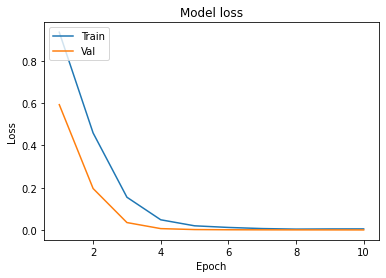

Confusion matrix, without normalization
[[20  0  0]
 [ 0 20  0]
 [ 0  0 20]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


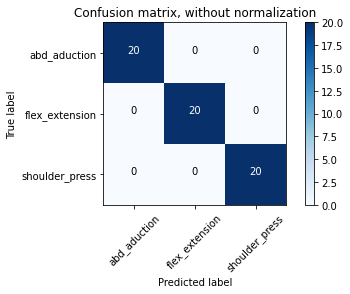

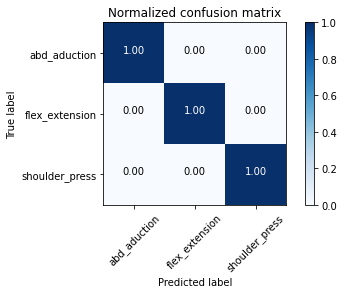

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import csv
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools
 
data = pd.read_csv('all.csv') 
#data = data.drop(data.columns[0],axis=1).copy() #this line is only for dropping the indexes if necessary
 
Fs = 5 #The data frequency is 5Hz approximately 
activities = data['Activity'].value_counts().index

def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    
    # for positions
    #plot_axis(ax0, data['Time'], data['ax'], 'X-Axis')
    #plot_axis(ax1, data['Time'], data['ay'], 'Y-Axis')
    #plot_axis(ax2, data['Time'], data['az'], 'Z-Axis')

    # for movements
    plot_axis(ax0, data['Time'], data['X'], 'X-Axis')
    plot_axis(ax1, data['Time'], data['Y'], 'Y-Axis')
    plot_axis(ax2, data['Time'], data['Z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
 
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

'''
##########
#This part creates the activities plot
for activity in activities:
    data_for_plot = data[(data['Activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

########
'''
label = LabelEncoder()
data['label'] = label.fit_transform(data['Activity'])
 
label.classes_ #It attributes to recover the mapping of classes shown below
#0=pointing downwards, 1=pointing upwards, 2=resting on the table <-> array(['pointing downwards', 'pointing upwards', 'resting on the table'],dtype=object)
#For movements ->  0=bench_press, 1=abd_adduction, 2=flex_extension <-> Index(['bench_press', 'abd_adduction', 'flex_extension'], dtype='object')
#array(['abd_aduction', 'flex_extension', 'shoulder_press'], dtype=object)

#X = data[['ax', 'ay', 'az']] #for positions
X = data[['X', 'Y', 'Z']] #for movements
y = data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# for positions
#scaled_X = pd.DataFrame(data = X, columns = ['ax', 'ay', 'az'])

#for movements
scaled_X = pd.DataFrame(data = X, columns = ['X', 'Y', 'Z'])
scaled_X['label'] = y.values
 
frame_size = Fs*4 # 20
hop_size = Fs*2 # 10
 
def get_frames(df, frame_size, hop_size):
 
    N_FEATURES = 3
 
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        
        # For positions
        #x = df['ax'].values[i: i + frame_size]
        #y = df['ay'].values[i: i + frame_size]
        #z = df['az'].values[i: i + frame_size]

        
        # for movements
        x = df['X'].values[i: i + frame_size]
        y = df['Y'].values[i: i + frame_size]
        z = df['Z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)
 
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
 
    return frames, labels
 
X, y = get_frames(scaled_X, frame_size, hop_size)

#Both data sets below are data of positions
#For the old set of data:
#I have 1110 observations for each of the 3 activities. Hence we have a total of (1110*3) observations. 
#This divided by the hop_size which is 10 is approximately 331. Hence we have 331 frames in our data.

#For the new set of data:
#I have 3530 observations for each of the 3 activities. Hence we have a total of (3530*3) observations. 
#This divided by the hop_size which is 10 is approximately 1057. And, dividing 1057 by 3, we have 331 frames in our data.

#For data of movements -> ((299, 20, 3),(299,))
X.shape, y.shape 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape 
# Old(test 20%): ((264, 20, 3), (67, 20, 3)) ; New(test 20%): ((845, 20, 3), (212, 20, 3)) ; movements: ((239, 20, 3), (60, 20, 3))

X_train = X_train.reshape(len(X_train), 20, 3, 1) # This 20 is because of frame_size = Fs*4 # 20
X_test = X_test.reshape(len(X_test), 20, 3, 1)
 
X_train[0].shape, X_test[0].shape
 
################# CNN Part #################################
 
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))
 
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))
 
model.add(Flatten())
 
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
 
model.add(Dense(3, activation='softmax'))

#### LEARNING RATE #####

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)
 
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
 
  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
 
plot_learningCurve(history, 10)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #This function prints and plots the confusion matrix.Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=-1)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# for positions
#class_names = ['pointing downwards', 'pointing upwards', 'resting on the table']

# for movements
#class_names = ['abd_adduction', 'bench_press', 'flex_extension']
class_names = ['abd_aduction', 'flex_extension', 'shoulder_press']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#this save function saves:
#the archiarchitecture of the model(allowing to re-create the model), weights, training configuration, and the state of the optimizer
model.save('model_moviments.h5')


In [ ]:
####################### Testing the model on new data #############################

from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

model = load_model('model_moviments.h5') # load the model

#data_fusion-mpu_phone\stored_data

#data_pred = pd.read_csv('acc_pred.csv') #downwards
#data_pred = pd.read_csv('acc_pred2.csv') #upwards
#data_pred = pd.read_csv('acc_pred3.csv') #rest

#data_pred = pd.read_csv('acc_pred_abd.csv') #abd_adduction
#data_pred = pd.read_csv('acc_pred_bench.csv') #bench_press
#data_pred = pd.read_csv('acc_pred_flex.csv') #flex_extension

#data_pred = pd.read_csv('abd_pred.csv') 
#data_pred = pd.read_csv('bench_pred.csv') 
#data_pred = pd.read_csv('flex_pred.csv') 

data_pred = pd.read_csv('abd_pred.csv') 
#data_pred = pd.read_csv('flex_pred.csv')
#data_pred = pd.read_csv('shoulder_pred.csv')  

#data_pred = data_pred.drop(data_pred.columns[[0,1]],axis=1).copy() #It drops the first 2 columns, when it is needed
#data_pred = data_pred.tail(100).drop(data_pred.columns[[0]],axis=1).copy() #It drops the first column(Activity), and the last 100 lines
data_pred = data_pred.drop(data_pred.columns[[0]],axis=1).copy() 

#X = data_pred[['ax', 'ay', 'az']] # for positions
X = data_pred[['X', 'Y', 'Z']] # for moviments

Fs = 5
frame_size = Fs*4 
hop_size = Fs*2

def frames(df, frame_size, hop_size):
 
    N_FEATURES = 3
 
    frames = []
    for i in range(0, len(df) - frame_size, hop_size):
        
        # for positions
        #x = df['ax'].values[i: i + frame_size]
        #y = df['ay'].values[i: i + frame_size]
        #z = df['az'].values[i: i + frame_size]

        # for movements
        x = df['X'].values[i: i + frame_size]
        y = df['Y'].values[i: i + frame_size]
        z = df['Z'].values[i: i + frame_size]
    
        frames.append([x, y, z])
 
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
  
    return frames
 
X = frames(X, frame_size, hop_size)
X = X.reshape(len(X), frame_size, 3, 1)

#class_names = ['abd_adduction', 'bench_press', 'flex_extension']

# model.predict() returns a number between 0 and 1, a probability. 
prediction = model.predict([X])
print(prediction)  # will be a list in a list.
classes = np.argmax(prediction, axis = 1)
classes 


[[1.00e+00 2.88e-11 4.93e-27]
 [1.00e+00 4.95e-10 2.27e-27]
 [1.00e+00 1.66e-09 2.28e-26]
 [1.00e+00 2.33e-10 9.32e-26]
 [1.00e+00 3.31e-09 1.33e-24]
 [1.00e+00 2.94e-09 2.83e-25]
 [1.00e+00 9.76e-10 9.75e-26]
 [1.00e+00 9.55e-10 1.47e-25]]


array([0, 0, 0, 0, 0, 0, 0, 0])